In [1]:
# inline plotting instead of popping out
%matplotlib inline

import os, math
from IPython.display import Image
import numpy as np
seed = np.random.seed

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)
df.columns = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width', 'Class label']
display(df.head())

X = df[['Petal length', 'Petal width']].values
y = pd.factorize(df['Class label'])[0]

# discard exmaples in the first class
X = X[50:150]
y = np.where(y[50:150] == 2, -1, y[50:150])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

print('# Training data points: %d' % X_train.shape[0])
print('# Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))

,Sepal length,Sepal width,Petal length,Petal width,Class label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


# Training data points: 80
# Testing data points: 20
Class labels: [-1  1]


In [9]:
class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int
        Set random state for shuffling and initializing the weights.
        
    """
    def __init__(self, eta=0.01, n_iter=50, shuffle=True, random_state=1, batch_size=1):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.batch_size = batch_size
        if random_state : seed(random_state)
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : array-like; shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like; shape = [n_samples]
            Target values or labels.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            mini_batches = self.create_mini_batches(X, y, self.batch_size)
            cost = []
            for mini_batch in mini_batches:
                X_mini, y_mini = mini_batch
                cost.append(self._update_weights(X_mini, y_mini))
            
            avg_cost = sum(cost) / len(mini_batches)
            self.cost_.append(avg_cost)
        return self

    def create_mini_batches(self, X, y, batch_size):
        """Create mini-batches from the dataset."""
        mini_batches = []
        data = np.column_stack((X, y))
        np.random.shuffle(data)
        n_minibatches = data.shape[0] // batch_size
        for i in range(n_minibatches):
            mini_batch = data[i * batch_size:(i + 1) * batch_size, :]
            X_mini = mini_batch[:, :-1]
            y_mini = mini_batch[:, -1].reshape(-1, 1)  # Reshape y to be a column vector
            mini_batches.append((X_mini, y_mini))
        if data.shape[0] % batch_size != 0:
            mini_batch = data[n_minibatches * batch_size:]
            X_mini = mini_batch[:, :-1]
            y_mini = mini_batch[:, -1].reshape(-1, 1)  # Reshape y to be a column vector
            mini_batches.append((X_mini, y_mini))
        return mini_batches

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Randomly initialize weights"""
        self.w_ = np.random.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, X, y):
        """Apply Adaline learning rule to update the weights for a batch."""
        outputs = self.activation(X)
        errors = y.ravel() - outputs  # Ensure y is flattened

        # Ensure errors is a 1D array
        errors = errors.ravel()

        # Calculate cost (mean squared error)
        cost = np.sum(0.5 * errors**2) / X.shape[0]

        # Update weights
        self.w_[1:] += self.eta * X.T.dot(errors) / X.shape[0]
        self.w_[0] += self.eta * np.sum(errors) / X.shape[0]

        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, yi in zip(X, y):
                self._update_weights(xi, yi)
        else:
            self._update_weights(X, y)
        return self

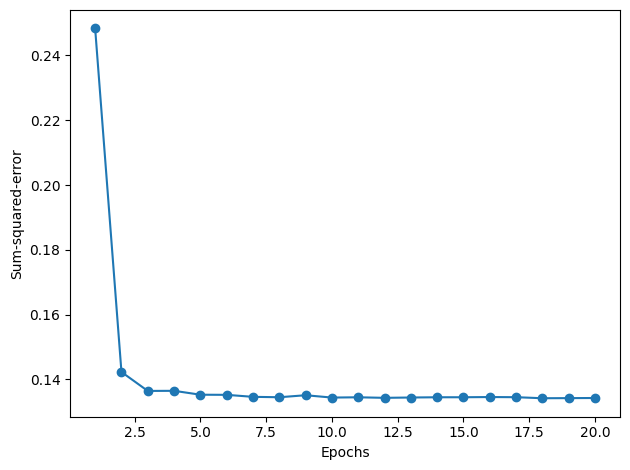

Misclassified samples: 3
Accuracy: 0.85


In [10]:
ada = AdalineSGD(n_iter=20, eta=0.01, random_state=1, batch_size=1)
ada.fit(X_train_std, y_train)

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')

plt.tight_layout()
plt.savefig('./output/test_1.png', dpi=300)
plt.show()

y_pred = ada.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

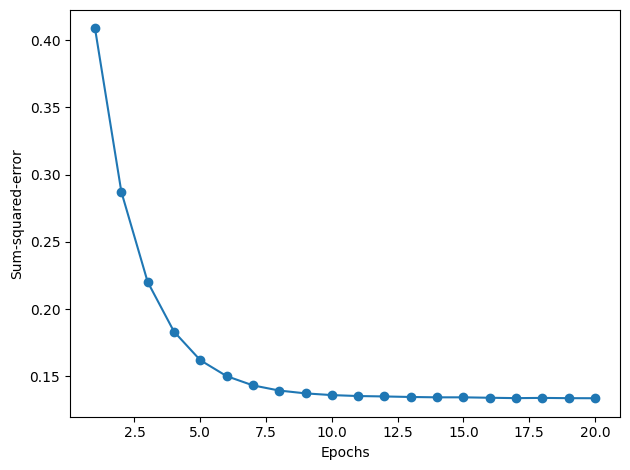

Misclassified samples: 3
Accuracy: 0.85


In [13]:
ada = AdalineSGD(n_iter=20, eta=0.01, random_state=1, batch_size=5)
ada.fit(X_train_std, y_train)

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')

plt.tight_layout()
plt.savefig('./output/test_1.png', dpi=300)
plt.show()

y_pred = ada.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

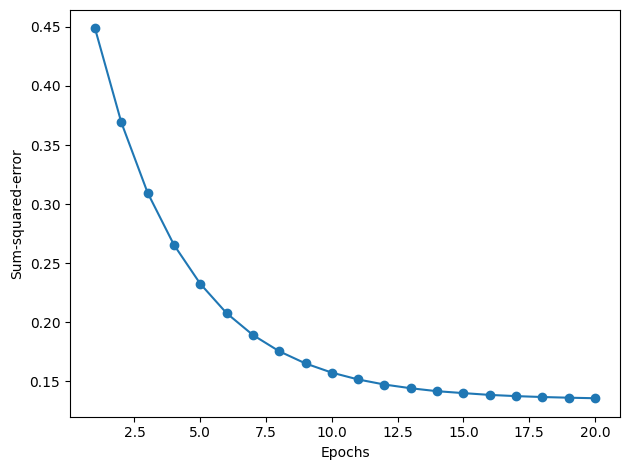

Misclassified samples: 3
Accuracy: 0.85


In [12]:
ada = AdalineSGD(n_iter=20, eta=0.01, random_state=1, batch_size=10)
ada.fit(X_train_std, y_train)

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')

plt.tight_layout()
plt.savefig('./output/test_1.png', dpi=300)
plt.show()

y_pred = ada.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

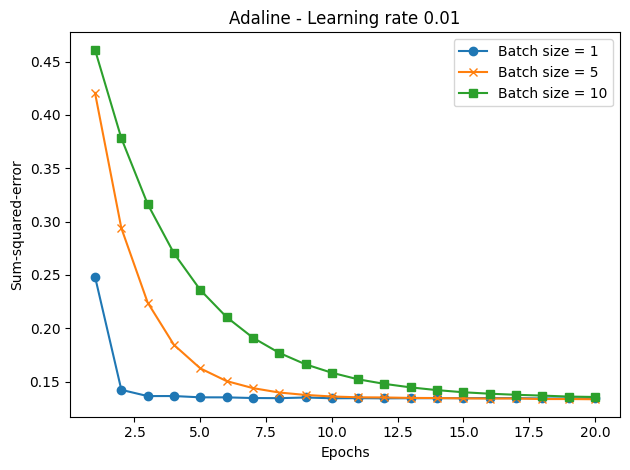

In [14]:
# Create instances of AdalineSGD with different batch sizes
ada1 = AdalineSGD(n_iter=20, eta=0.01, random_state=1, batch_size=1)
ada5 = AdalineSGD(n_iter=20, eta=0.01, random_state=1, batch_size=5)
ada10 = AdalineSGD(n_iter=20, eta=0.01, random_state=1, batch_size=10)

# Fit each classifier on the training data
ada1.fit(X_train_std, y_train)
ada5.fit(X_train_std, y_train)
ada10.fit(X_train_std, y_train)

# Plotting the sum-squared-error for each batch size
plt.plot(range(1, len(ada1.cost_) + 1), ada1.cost_, marker='o', label='Batch size = 1')
plt.plot(range(1, len(ada5.cost_) + 1), ada5.cost_, marker='x', label='Batch size = 5')
plt.plot(range(1, len(ada10.cost_) + 1), ada10.cost_, marker='s', label='Batch size = 10')

plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.title('Adaline - Learning rate 0.01')
plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('./output/compare_batch_sizes.png', dpi=300)
plt.show()